In [ ]:
import cv2
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier("/content/drive/My Drive/haarcascade_frontalface_default.xml")

# Function to load images, detect faces, and prepare them for feature extraction
def load_and_detect_faces(folder_path):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Detect face
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w]  # Crop to face region
                        images.append(face_region)
                        labels.append(label)
    return images, labels

In [ ]:
# Set paths for training and testing folders
train_folder_path = "/content/drive/My Drive/CK_dataset/train"
test_folder_path = "/content/drive/My Drive/CK_dataset/test"

# Load and detect faces in training and testing data
X_train, y_train = load_and_detect_faces(train_folder_path)
X_test, y_test = load_and_detect_faces(test_folder_path)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Preprocess the images with histogram equalization
def preprocess_images(images):
    preprocessed_images = []
    for img in images:
        # Apply histogram equalization to improve contrast
        img = cv2.equalizeHist(img)
        preprocessed_images.append(img)
    return preprocessed_images


# Define parameters for LBP
radius = 1
n_points = 8 * radius

# Function to extract LBP features from the cropped face images
def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        # Resize face image to a standard size if needed
        img = cv2.resize(img, (64, 64))  # Standardize size
        lbp = local_binary_pattern(img, n_points, radius, method="uniform")
        # Histogram of LBP patterns
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        # Normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbp_features.append(hist)
    return np.array(lbp_features)

# Extract LBP features from training and testing face regions
X_train_features = extract_lbp_features(X_train)
X_test_features = extract_lbp_features(X_test)


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create an SVM pipeline with scaling and RBF kernel
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=12, gamma='scale'))

# Train and evaluate the model
svm_classifier.fit(X_train_features, y_train)
y_pred = svm_classifier.predict(X_test_features)

# Train the classifier on the training features
svm_classifier.fit(X_train_features, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=12))])

In [16]:
# Predict the test set results
y_pred = svm_classifier.predict(X_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(len(y_test))
print(conf_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy: 37.06%
143
[[ 6  0  7  4  1  0]
 [ 1  0  0  4  2  0]
 [ 2  0 13  7  2  6]
 [ 2  0  7 14  1 12]
 [ 1  0  5  3  4  4]
 [ 2  1  6  7  3 16]]
              precision    recall  f1-score   support

       anger       0.43      0.33      0.38        18
        fear       0.00      0.00      0.00         7
       happy       0.34      0.43      0.38        30
     neutral       0.36      0.39      0.37        36
     sadness       0.31      0.24      0.27        17
    surprise       0.42      0.46      0.44        35

    accuracy                           0.37       143
   macro avg       0.31      0.31      0.31       143
weighted avg       0.36      0.37      0.36       143



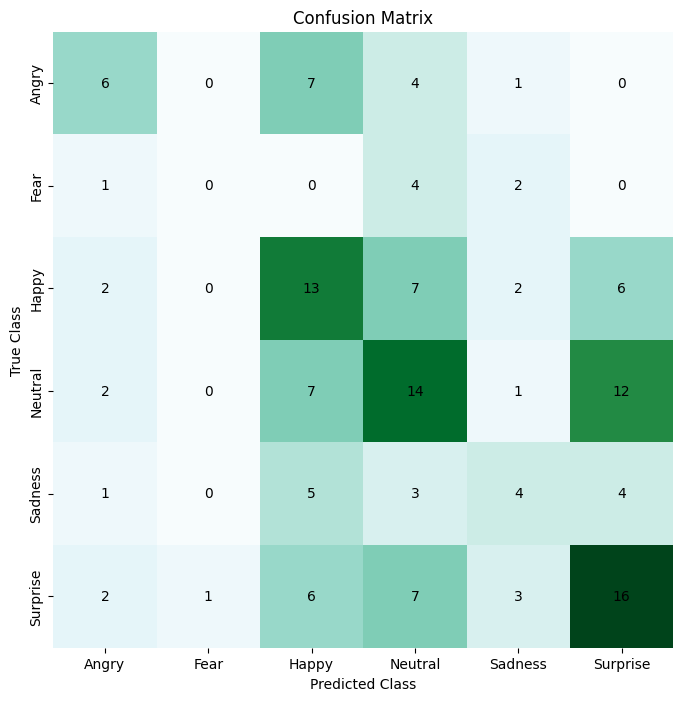

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming class names are defined
class_names = ["Angry", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix with class names
plt.figure(figsize=(8, 8))
ax = sns.heatmap(conf_matrix, annot=False, cmap="BuGn", xticklabels=class_names, yticklabels=class_names, cbar=False)

# Add annotations with both counts and percentages
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}", ha="center", va="center", color="black", fontsize=10)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()


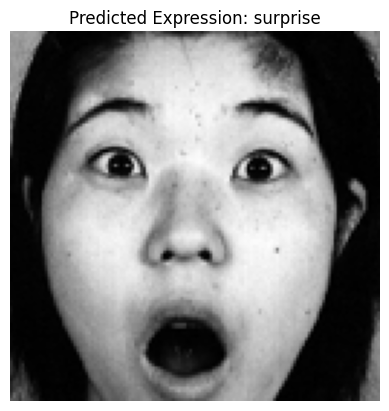

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess and extract LBP features from a single image
def preprocess_and_extract_features(image_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or could not be loaded.")

    # Resize image to a standard size (if needed)
    img = cv2.resize(img, (64, 64))

    # Apply LBP
    lbp = local_binary_pattern(img, n_points, radius, method="uniform")

    # Compute the histogram of LBP patterns
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)

    return hist.reshape(1, -1)  # Return as a 2D array for model input


# Function to predict and display the expression of a single image
def predict_emotion(image_path, model):
    # Extract features
    features = preprocess_and_extract_features(image_path)

    # Predict the expression (directly get the predicted label as a string)
    predicted_expression = model.predict(features)[0]

    # Load and display the image with predicted label
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

    plt.imshow(img_rgb)
    plt.title(f"Predicted Expression: {predicted_expression}")
    plt.axis('off')
    plt.show()


image_path = "/content/drive/My Drive/testimages/23.tiff"  # Example path to an image
predict_emotion(image_path, svm_classifier)



In [ ]:
# Set paths for training and testing folders
train_folder_path = "/content/drive/My Drive/CK_dataset/train"
test_folder_path = "/content/drive/My Drive/CK_dataset/test"

# Load and detect faces in training and testing data
X_train, y_train = load_and_detect_faces(train_folder_path)
X_test, y_test = load_and_detect_faces(test_folder_path)